#Run using python, no GPU needed

In [47]:
!pip install rsatoolbox

#LSTM with MNSIT Dataset - Representational Dissimilarity Matrix (RDM)

In [48]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import rsatoolbox
from rsatoolbox.data import Dataset
from rsatoolbox.rdm import calc_rdm
from rsatoolbox.vis import show_rdm

# -----------------------
# 1. Define LSTM Model
# -----------------------
class LSTMClassifier(nn.Module):
    def __init__(self, input_size=28, hidden_size=64, num_layers=1, num_classes=10):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.hidden = None  # for internal activations

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)  # out: [B, T, H]; hn, cn: [num_layers, B, H]
        self.hidden = {
            'hn': hn[-1].detach().cpu().numpy(),             # [B, H]
            'cn': cn[-1].detach().cpu().numpy(),             # [B, H]
            'avg_out': out.mean(dim=1).detach().cpu().numpy()  # [B, H]
        }
        out = self.fc(hn[-1])
        return out

# -----------------------
# 2. Load MNIST Data
# -----------------------
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

# -----------------------
# 3. Train for 1 Epoch
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.train()
for epoch in range(1):  # short training
    for images, labels in trainloader:
        images = images.squeeze(1).to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

print("Training complete.")

# --------------------------
# 4. Collect Internal Layers
# --------------------------
model.eval()
labels_list = []
hn_list, cn_list, avg_out_list = [], [], []

with torch.no_grad():
    counts = [0]*10
    for images, labels in trainloader:
        images = images.squeeze(1).to(device)
        labels = labels.to(device)

        _ = model(images)  # forward pass, fills model.hidden

        for i in range(images.size(0)):
            digit = labels[i].item()
            if counts[digit] < 10:
                hn_list.append(model.hidden['hn'][i])
                cn_list.append(model.hidden['cn'][i])
                avg_out_list.append(model.hidden['avg_out'][i])
                labels_list.append(str(digit))
                counts[digit] += 1
        print("hn shape:", np.array(hn_list).shape)
        print("hn std:", np.std(hn_list))
        print("cn std:", np.std(cn_list))
        print("avg_out std:", np.std(avg_out_list))

        if all(c >= 10 for c in counts):
            break

# --------------------------
# 5. Wrap into RSA Datasets
# --------------------------
def to_rsa_dataset(activations, labels):
    return Dataset(
        measurements=np.array(activations),
        descriptors={'session': 1},
        obs_descriptors={'digit': labels}
    )

datasets = {
    'LSTM Hidden State (hn)': to_rsa_dataset(hn_list, labels_list),
    'LSTM Cell State (cn)': to_rsa_dataset(cn_list, labels_list),
    'LSTM Output Mean Over Time': to_rsa_dataset(avg_out_list, labels_list)
}


Training complete.
hn shape: (98, 64)
hn std: 0.75499845
cn std: 2.7820714
avg_out std: 0.42332077
hn shape: (100, 64)
hn std: 0.7542352
cn std: 2.7806058
avg_out std: 0.42424992


#Visualizing RDM during Training

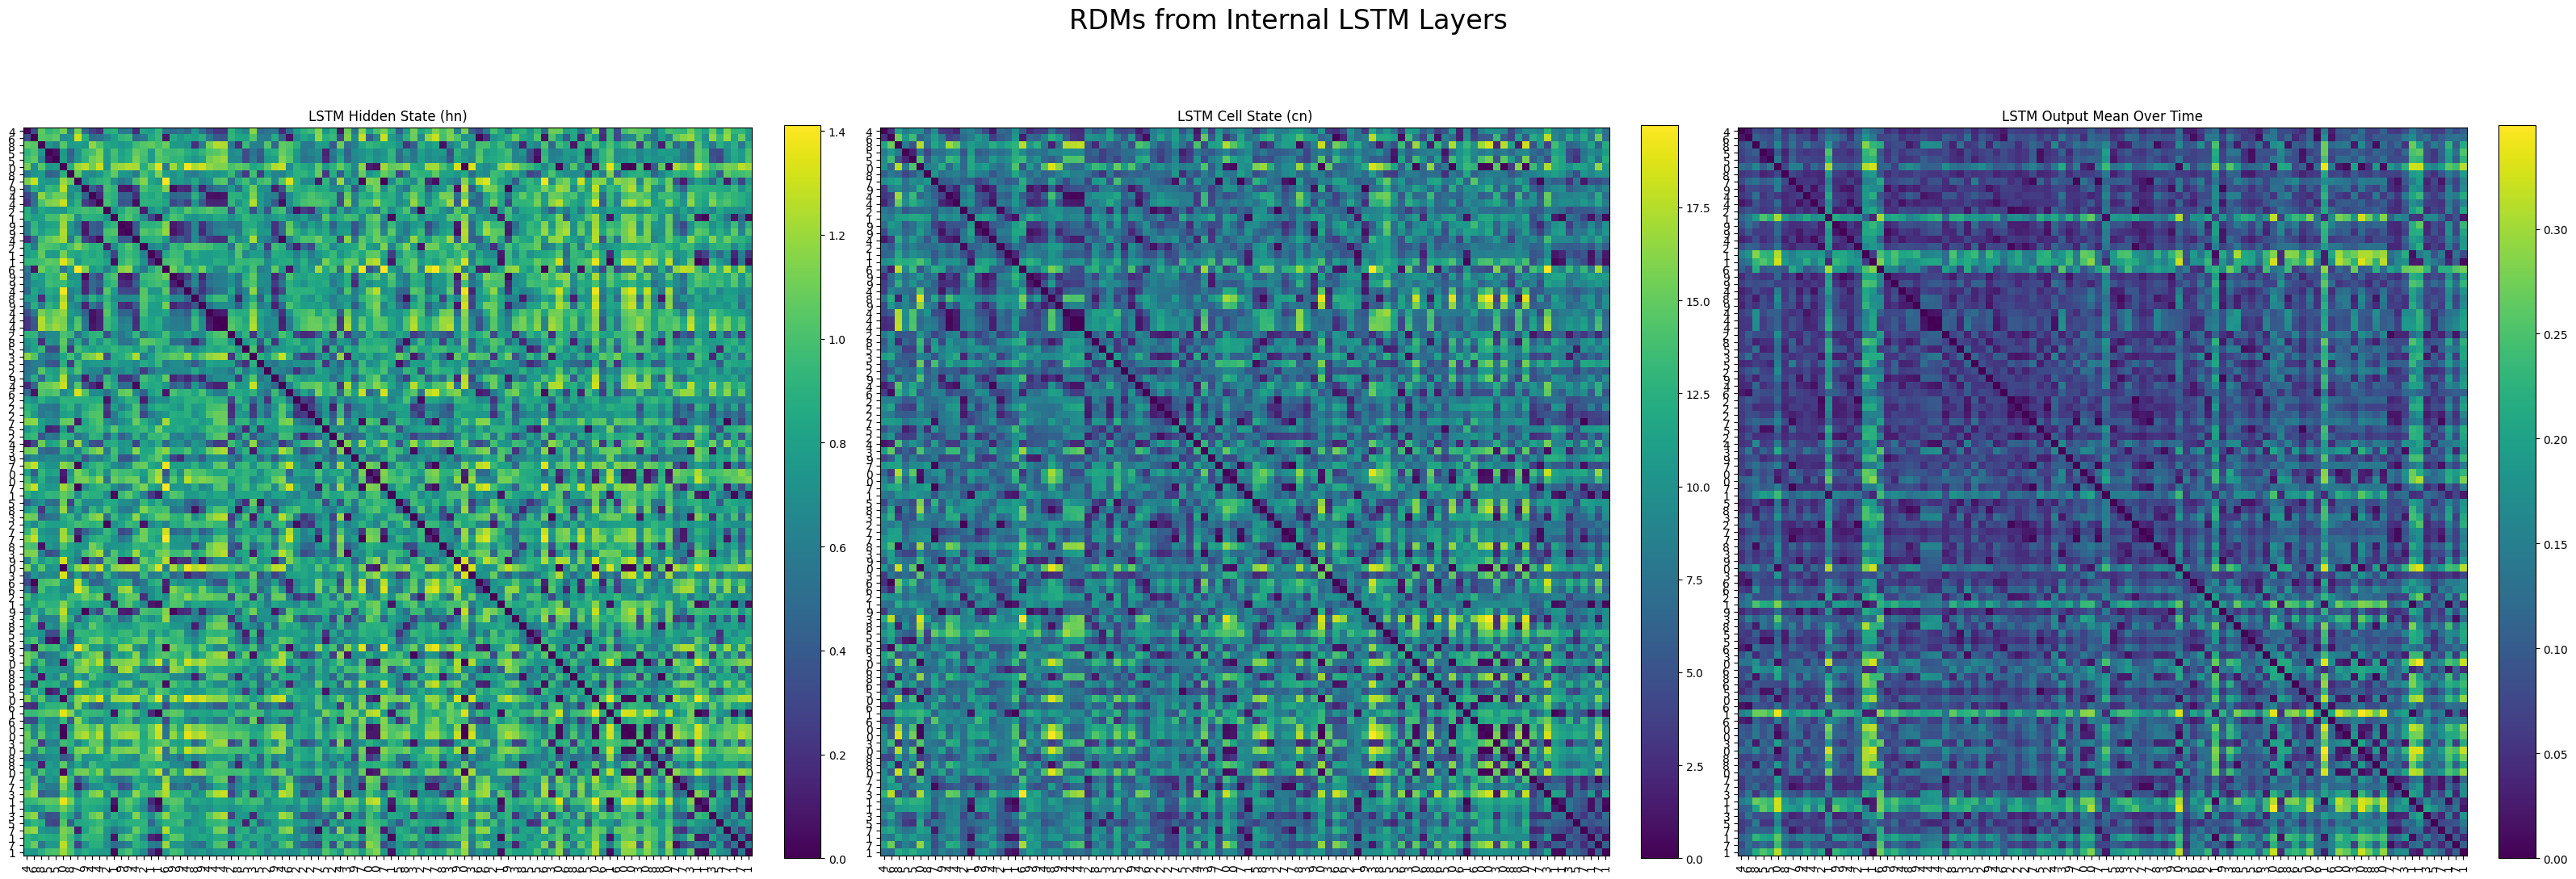

In [49]:
#import matplotlib.pyplot as plt
#from rsatoolbox.rdm import calc_rdm

# Store the three RDMs
rdm_matrices = {}
for name, data in datasets.items():
    rdm = calc_rdm(data, method='euclidean')
    rdm_matrices[name] = (rdm.get_matrices()[0], data.obs_descriptors['digit'])

# Plot them in subplots using imshow
fig, axes = plt.subplots(1, 3, figsize=(32, 12))

for ax, (title, (rdm_matrix, labels)) in zip(axes, rdm_matrices.items()):
    im = ax.imshow(rdm_matrix, cmap='viridis')
    #print(labels)
    ax.set_title(title)
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticklabels(labels)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle("RDMs from Internal LSTM Layers", fontsize=24)
plt.tight_layout()
plt.show()


#Testing Phase

In [50]:
# -----------------------
# 7. Evaluate on Test Set
# -----------------------
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

def evaluate(model, dataloader):
    model.eval()
    total = 0
    correct = 0
    total_loss = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.squeeze(1).to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

# Run evaluation
test_loss, test_acc = evaluate(model, testloader)
print(f"\n Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc * 100:.2f}%")



 Test Loss: 0.3022, Test Accuracy: 91.00%


In [51]:
# --------------------------
# Extract test set activations
# --------------------------
model.eval()
labels_list_test = []
hn_list_test, cn_list_test, avg_out_list_test = [], [], []

with torch.no_grad():
    counts = [0] * 10
    for images, labels in testloader:
        images = images.squeeze(1).to(device)
        labels = labels.to(device)

        out, (hn, cn) = model.lstm(images)  # Forward through LSTM directly
        hn = hn[-1].cpu().numpy()           # Last hidden state
        cn = cn[-1].cpu().numpy()           # Last cell state
        avg_out = out.mean(dim=1).cpu().numpy()  # Avg over time steps

        for i in range(images.size(0)):
            digit = labels[i].item()
            if counts[digit] < 10:
                hn_list_test.append(hn[i])
                cn_list_test.append(cn[i])
                avg_out_list_test.append(avg_out[i])
                labels_list_test.append(str(digit))
                counts[digit] += 1

        if all(c >= 10 for c in counts):
            break


#Visualizing RDMs during testing

In [52]:
def to_rsa_dataset(activations, labels):
    return rsatoolbox.data.Dataset(
        measurements=np.array(activations),
        descriptors={'session': 'test'},
        obs_descriptors={'digit': labels}
    )

datasets_test = {
    'Test Hidden State (hn)': to_rsa_dataset(hn_list_test, labels_list_test),
    'Test Cell State (cn)': to_rsa_dataset(cn_list_test, labels_list_test),
    'Test Output Mean Over Time': to_rsa_dataset(avg_out_list_test, labels_list_test)
}


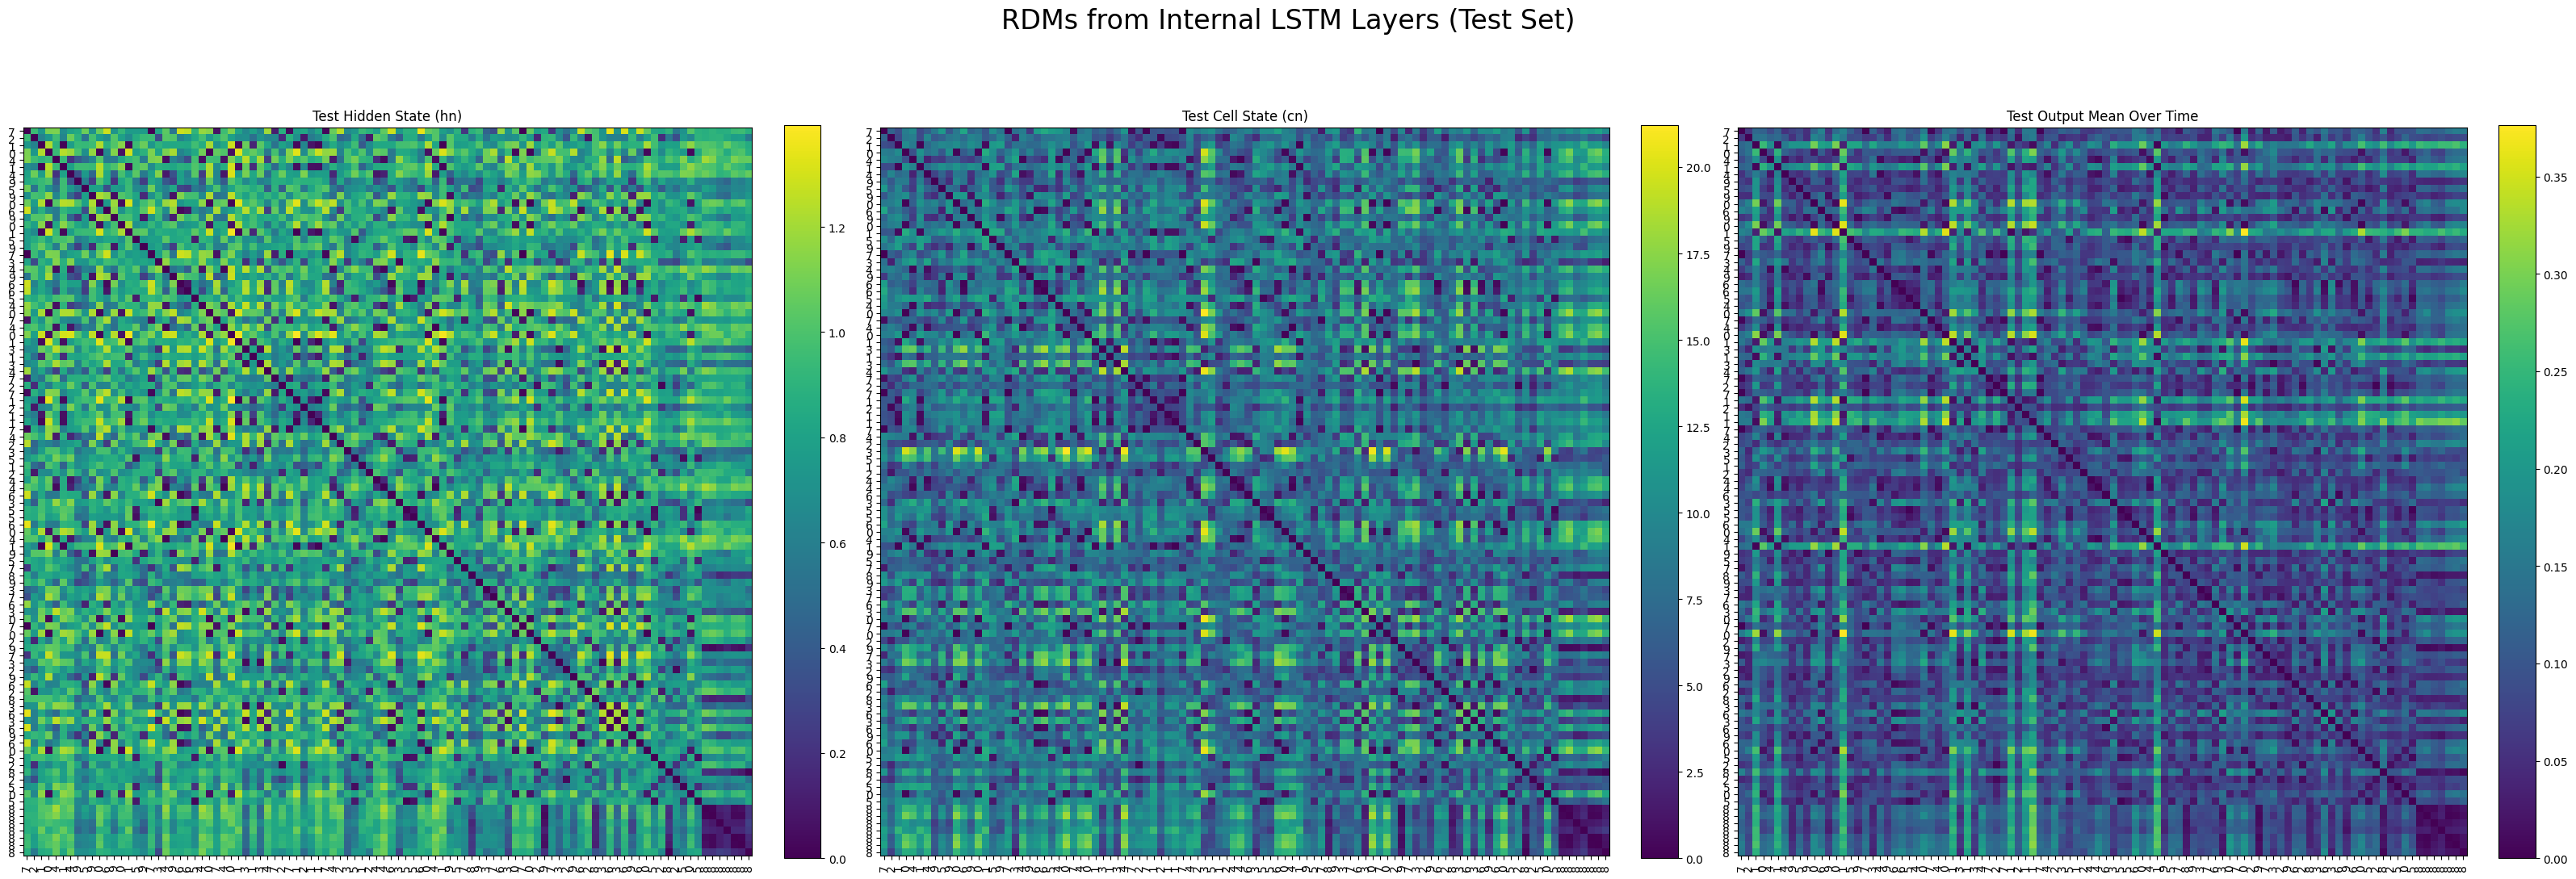

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(32, 12))

for ax, (title, data) in zip(axes, datasets_test.items()):
    rdm = calc_rdm(data, method='euclidean')
    rdm_matrix = rdm.get_matrices()[0]
    labels = data.obs_descriptors['digit']

    im = ax.imshow(rdm_matrix, cmap='viridis')
    ax.set_title(title)
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticklabels(labels)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle("RDMs from Internal LSTM Layers (Test Set)", fontsize=24)
plt.tight_layout()
plt.show()
